# Importing libraries


In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import random
import joblib

# Exploring the tables

In [157]:
# Loading data
counties = pd.read_csv(".\counties.csv", sep = ";")
crashes_poverty = pd.read_csv(".\crashes_poverty.csv", sep = ";")
vehicles = pd.read_csv(r".\vehicles.csv")

In [6]:
counties.info()
counties.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   State         59 non-null     object
 1   Abbreviation  59 non-null     object
 2   Postal
code   59 non-null     object
dtypes: object(3)
memory usage: 1.5+ KB


,State,Abbreviation,Postal\ncode
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,American Samoa,,AS
3,Arizona,Ariz.,AZ
4,Arkansas,Ark.,AR


In [7]:
crashes_poverty.info()
crashes_poverty.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   State              50 non-null     object 
 1   Number of Crashes  50 non-null     int64  
 2   Poverty            50 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ KB


,State,Number of Crashes,Poverty
0,Florida,1011,13.70
1,Tennessee,437,15.20
2,New Mexico,344,18.80
3,Alabama,336,16.80
4,Louisiana,271,18.70


In [5]:
# Join counties and crashes_poverty tables
crashes_poverty1 = pd.merge(counties[["State","Postal\ncode"]],crashes_poverty, how='left', on='State')

# Lowercase postalcode so it can be used as a key
crashes_poverty1["Postal\ncode"] = crashes_poverty1["Postal\ncode"].str.lower()
crashes_poverty1.head(5)


,State,Postal\ncode,Number of Crashes,Poverty
0,Alabama,al,336.00,16.80
1,Alaska,ak,32.00,11.10
2,American Samoa,as,NaN,NaN
3,Arizona,az,249.00,14.10
4,Arkansas,ar,143.00,16.80


## Exploring and understanding vehicles data

In [9]:
# Exploring vehicles data
vehicles.info()
vehicles.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26988 entries, 0 to 26987
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        26988 non-null  object 
 1   price         26988 non-null  int64  
 2   year          26938 non-null  float64
 3   manufacturer  25794 non-null  object 
 4   model         26565 non-null  object 
 5   condition     15344 non-null  object 
 6   cylinders     15682 non-null  object 
 7   fuel          26820 non-null  object 
 8   odometer      21993 non-null  float64
 9   title_status  26851 non-null  object 
 10  transmission  26752 non-null  object 
 11  vin           16116 non-null  object 
 12  drive         18992 non-null  object 
 13  size          8346 non-null   object 
 14  type          19827 non-null  object 
 15  paint_color   18198 non-null  object 
 16  description   26985 non-null  object 
 17  county        0 non-null      float64
 18  state         26988 non-nu

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,description,county,state,lat,long
0,palm springs,3400,2002.00,volkswagen,jetta gls,excellent,4 cylinders,gas,100000.00,clean,automatic,WVWSK61J62W209823,NaN,NaN,wagon,NaN,This 2002 Volkswagen Jetta GLS Wagon is simply...,NaN,ca,33.75,-116.35
1,salem,6300,2004.00,chevrolet,silverado 2500 crew cab,NaN,8 cylinders,gas,208942.00,clean,automatic,1GCHK23U94F144317,4wd,NaN,pickup,white,We want to let you know up front that Synergiz...,NaN,or,44.92,-123.32
2,long island,9997,2011.00,nissan,xterra,excellent,NaN,gas,125666.00,clean,automatic,5N1AN0NWXBC502031,NaN,NaN,NaN,NaN,Year : 2011 \t\t Make : NISSAN \t\t\tMode...,NaN,ny,40.80,-73.01
3,amarillo,21504,2017.00,chevrolet,malibu,NaN,4 cylinders,gas,24218.00,clean,automatic,NaN,fwd,mid-size,sedan,red,Use this link to see more information on this ...,NaN,tx,35.18,-101.79
4,inland empire,28900,2009.00,cadillac,cts-v,excellent,8 cylinders,gas,61000.00,clean,automatic,NaN,rwd,mid-size,sedan,silver,"2009 CTS-V, FAST! Awesome car, super clean, we...",NaN,ca,33.97,-117.56


In [10]:
# Reviewing nulls
print(vehicles.shape)
100*vehicles.isnull().sum()/vehicles.shape[0]

(26988, 21)


region           0.00
price            0.00
year             0.19
manufacturer     4.42
model            1.57
condition       43.15
cylinders       41.89
fuel             0.62
odometer        18.51
title_status     0.51
transmission     0.87
vin             40.28
drive           29.63
size            69.08
type            26.53
paint_color     32.57
description      0.01
county         100.00
state            0.00
lat              1.33
long             1.33
dtype: float64

In [6]:
# cleasing 1: droping null fiels
vehicles.drop(columns=['county'], inplace=True)
print(vehicles.shape)
vehicles.head(3)

(26988, 20)


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,description,state,lat,long
0,palm springs,3400,2002.00,volkswagen,jetta gls,excellent,4 cylinders,gas,100000.00,clean,automatic,WVWSK61J62W209823,NaN,NaN,wagon,NaN,This 2002 Volkswagen Jetta GLS Wagon is simply...,ca,33.75,-116.35
1,salem,6300,2004.00,chevrolet,silverado 2500 crew cab,NaN,8 cylinders,gas,208942.00,clean,automatic,1GCHK23U94F144317,4wd,NaN,pickup,white,We want to let you know up front that Synergiz...,or,44.92,-123.32
2,long island,9997,2011.00,nissan,xterra,excellent,NaN,gas,125666.00,clean,automatic,5N1AN0NWXBC502031,NaN,NaN,NaN,NaN,Year : 2011 \t\t Make : NISSAN \t\t\tMode...,ny,40.80,-73.01


In [7]:
# Reviewing duplicates, i can do this since is a small dataset
percentage = (vehicles.duplicated().value_counts(True)*100)[1].round(2)
print(f'The {percentage:.2f}% are duplicated in the dataset\t')
print(vehicles.duplicated().value_counts())
vehicles.duplicated().value_counts(True)*100

The 0.86% are duplicated in the dataset	
False    26757
True       231
dtype: int64


False   99.14
True     0.86
dtype: float64

In [8]:
# Remove 231 duplicates
vehicles = vehicles.drop_duplicates()
vehicles.duplicated().value_counts()

False    26757
dtype: int64

In [9]:
# reviewing duplicated records by vin
percentage = (vehicles['vin'].duplicated().value_counts(True)*100)[1].round(2)
print(f'The {percentage:.2f}% are duplicated\t')
print(vehicles['vin'].duplicated().value_counts())
vehicles['vin'].duplicated().value_counts(True)*100

The 44.65% are duplicated	
False    14810
True     11947
Name: vin, dtype: int64


False   55.35
True    44.65
Name: vin, dtype: float64

In [10]:
print(vehicles[vehicles['vin'].duplicated()==True].sort_values('vin')['vin'].value_counts())
print(vehicles[vehicles['vin'].duplicated()==True]['vin'].unique())

WDZPE7CC9D5767661    12
WP0CA2991XS652065     6
1FTEW1CP1HKC20511     4
1ZVBP8FF4C5208577     4
1FTEW1CPXGKE39286     4
                     ..
1GKS2CKJ2FR595310     1
1GKUKEEF1AR114273     1
1GKUKEEF3AR281007     1
1GNEK13T75R148328     1
na                    1
Name: vin, Length: 960, dtype: int64
[nan '1C6RR7LT0ES407525' 'JN8CS1MU4GM670538' '1Z37T3S423413'
 '1FTNX21F33EA58482' '1GCUYDED9KZ234570' '77777777777777777'
 '1GB0G2CF4F1120818' 'JTHBE1D20G5026007' '5GRGN23U53H104188'
 '1C4RJEAG4CC259705' '1N6DD0CW5HN700789' '1GTR1UEH5FZ359102'
 '5TFTX4CN7FX068111' '5TFAX5GN0HX094592' '1N6AD0EV0JN736421'
 '5YFBU4EE5DP213613' '19XFB2F5XDE045981' 'JN8AZ08T56W404091'
 '1FUJGLBG4CSBR9294' '1GCGSDE10J1275283' 'JT2BF28K7W0105290'
 '1GT12YEG4FF154252' '5UXKR6C54E0J71512' '1FA6P8TH4J5185525'
 '1G1PC5SB1D7149766' '3D73Y4CL0BG514891' '1N6AD0EV7KN722632'
 '1D7RV1GT8BS542653' '1G1BE5SM4H7122718' '1HGES26785L018981'
 '1FA6P8TH4H5217450' 'JF1ZCAC17D1601131' '3GNTKGE76CG130149'
 '1G1FA3DS3G0160509' '1FTEW1

The below chunk of code are dedicated to explore the some of the vins so we can understand where is the duplicity located

In [16]:
vehicles[vehicles['vin']=='WDZPE7CC9D5767661']

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,description,state,lat,long
3363,stockton,34900,2013.00,mercedes-benz,benze sprinter 2500,excellent,6 cylinders,diesel,23893.00,clean,automatic,WDZPE7CC9D5767661,rwd,NaN,van,black,Call/Text Jim anytime: 936-349-6038 2013 Merc...,ca,30.95,-95.91
5546,north central FL,34900,2013.00,mercedes-benz,benze sprinter 2500,excellent,6 cylinders,diesel,23893.00,clean,automatic,WDZPE7CC9D5767661,rwd,NaN,van,black,Call/Text Jim anytime: 936-349-6038 2013 Merc...,fl,30.95,-95.91
7086,imperial county,34900,2013.00,mercedes-benz,benze sprinter 2500,excellent,6 cylinders,diesel,23893.00,clean,automatic,WDZPE7CC9D5767661,rwd,NaN,van,black,Call/Text Jim anytime: 936-349-6038 2013 Merc...,ca,30.95,-95.91
7396,eugene,34900,2013.00,mercedes-benz,benze sprinter 2500,excellent,6 cylinders,diesel,23893.00,clean,automatic,WDZPE7CC9D5767661,rwd,NaN,van,black,Call/Text Jim anytime: 936-349-6038 2013 Merc...,or,30.95,-95.91
8319,ventura county,34900,2013.00,mercedes-benz,benze sprinter 2500,excellent,6 cylinders,diesel,23893.00,clean,automatic,WDZPE7CC9D5767661,rwd,NaN,van,black,Call/Text Jim anytime: 936-349-6038 2013 Merc...,ca,30.95,-95.91
12116,north jersey,34900,2013.00,mercedes-benz,benze sprinter 2500,excellent,6 cylinders,diesel,23893.00,clean,automatic,WDZPE7CC9D5767661,rwd,NaN,van,black,Call/Text Jim anytime: 936-349-6038 2013 Merc...,nj,30.95,-95.91
16689,columbus,34900,2013.00,mercedes-benz,benze sprinter 2500,excellent,6 cylinders,diesel,23893.00,clean,automatic,WDZPE7CC9D5767661,rwd,NaN,van,black,Call/Text Jim anytime: 936-349-6038 2013 Merc...,oh,30.95,-95.91
18080,stockton,34900,2013.00,mercedes-benz,benze sprinter 2500,excellent,6 cylinders,diesel,23893.00,clean,automatic,WDZPE7CC9D5767661,rwd,NaN,van,black,Call/Text Jim anytime: 936-349-6038 2013 Merc...,ca,30.95,-95.91
18384,lincoln,34900,2013.00,mercedes-benz,benze sprinter 2500,excellent,6 cylinders,diesel,23893.00,clean,automatic,WDZPE7CC9D5767661,rwd,NaN,van,black,Call/Text Jim anytime: 936-349-6038 2013 Merc...,ne,30.95,-95.91
21529,space coast,34900,2013.00,mercedes-benz,benze sprinter 2500,excellent,6 cylinders,diesel,23893.00,clean,automatic,WDZPE7CC9D5767661,rwd,NaN,van,black,Call/Text Jim anytime: 936-349-6038 2013 Merc...,fl,30.95,-95.91


Q1: Why there are vehicles with the same vim, under different regions witht he same odometer? it could be error of the data source?
Insigh: Over all duplicated vims there are 960 who have this condition (different region) this represents the 960/11947 8%

In [17]:
vehicles[vehicles['vin']=='1GKS2CKJ2FR595310']

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,description,state,lat,long
18055,lubbock,31998,2015.00,gmc,yukon,NaN,NaN,gas,76437.00,clean,automatic,1GKS2CKJ2FR595310,4wd,NaN,SUV,white,2015 GMC Yukon Denali 4x4 4dr SUV Offered ...,tx,33.58,-101.85
22640,amarillo,31998,2015.00,gmc,yukon,NaN,NaN,gas,76437.00,clean,automatic,1GKS2CKJ2FR595310,4wd,NaN,SUV,white,2015 GMC Yukon Denali 4x4 4dr SUV Offered ...,tx,33.58,-101.85


Conclusion: Region fields is not clear, since apparently there are some regions with different state and lat/lon

### VIN field Analysis

Over this field I am going to fix only the recods who are duplicated, since i found non conventional patterns such as 0000

In [11]:
# distribution of the vim's lenght
print(vehicles['vin'].str.len().value_counts())
vehicles['vin'].str.len().value_counts(True)*100


17.00    15716
6.00        58
13.00       38
16.00       33
11.00       27
10.00       27
8.00        25
12.00       16
9.00        14
5.00        11
14.00       11
15.00        8
4.00         7
7.00         7
3.00         5
2.00         3
18.00        3
1.00         3
Name: vin, dtype: int64


17.00   98.15
6.00     0.36
13.00    0.24
16.00    0.21
11.00    0.17
10.00    0.17
8.00     0.16
12.00    0.10
9.00     0.09
5.00     0.07
14.00    0.07
15.00    0.05
4.00     0.04
7.00     0.04
3.00     0.03
2.00     0.02
18.00    0.02
1.00     0.02
Name: vin, dtype: float64

The 98% of the vins have 17 characteres long

In [12]:
vehicles_dupli_vin = vehicles[vehicles['vin'].duplicated()]#['vin'].str.len().value_counts()
vehicles_dupli_vin['vin_len'] = vehicles['vin'].str.len()
vehicles_dupli_vin[vehicles_dupli_vin['vin_len'].between(1,16)].sort_values('vin_len')

C:\Users\efrag\AppData\Local\Temp\ipykernel_20144\3331196919.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehicles_dupli_vin['vin_len'] = vehicles['vin'].str.len()


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,description,state,lat,long,vin_len
19586,palm springs,5500,1991.00,mercedes-benz,500sl,good,8 cylinders,gas,84000.00,clean,automatic,1,4wd,full-size,convertible,red,Red. 84k miles. Great shape. It has a vacuum l...,ca,34.15,-116.30,1.00
21457,green bay,6250,1968.00,chrysler,300,good,8 cylinders,gas,0.00,clean,automatic,na,rwd,full-size,coupe,green,1968 Chrysler 300 project. Comes with a 1968 ...,wi,44.05,-87.82,2.00
8035,medford-ashland,4950,2006.00,chevrolet,suburban,excellent,8 cylinders,gas,204000.00,clean,automatic,0000,NaN,full-size,SUV,NaN,2006 Chevy Suburban High miles but still driv...,or,42.43,-122.84,4.00
24981,stockton,22648,2016.00,ford,f150 super cab 4x4,like new,8 cylinders,gas,87890.00,clean,automatic,D00341,4wd,NaN,truck,white,"2016 FORD F150 SUPER CAB XL 4WD 8FT BED, V8 5....",ca,37.77,-120.85,6.00
23897,bakersfield,35999,2018.00,lexus,rc 300 f sport,like new,4 cylinders,gas,9000.00,clean,automatic,784512,rwd,mid-size,coupe,red,Managers Special!! 2018 Lexus RC300 F Sport - ...,ca,36.82,-119.69,6.00
18229,austin,28750,1957.00,NaN,Porsche Speedster 1991 kit,excellent,4 cylinders,gas,0.00,clean,manual,AZ152792,NaN,NaN,convertible,NaN,1957 Porsche Speedster 1991 Volkswagen Replic...,tx,33.74,-116.36,8.00
16804,richmond,9975,1992.00,NaN,Suzuki Very RARE Jimny Turbo,excellent,3 cylinders,gas,29962.00,clean,automatic,JA11208484,NaN,NaN,SUV,NaN,1992 Suzuki Very RARE Jimny Turbo 1 OWNER SU...,va,33.74,-116.36,10.00
15633,orlando,46500,1948.00,mercury,convertible,NaN,8 cylinders,gas,999999.00,clean,manual,899A215197,NaN,NaN,NaN,NaN,Lost and Found Classic Car Co. 1200 W. Divisi...,fl,48.40,-122.37,10.00
25254,bellingham,46500,1948.00,mercury,convertible,NaN,8 cylinders,gas,999999.00,clean,manual,899A215197,NaN,NaN,NaN,NaN,Lost and Found Classic Car Co. 1200 W. Divisi...,wa,48.40,-122.37,10.00
8676,tampa bay area,5875,1966.00,dodge,dart gt,good,8 cylinders,gas,50000.00,clean,automatic,000000000000,rwd,NaN,convertible,yellow,He we have a lovely Dodge Dart GT Convertible ...,fl,27.99,-82.37,12.00


In [13]:
# over the duplicated vins, i analyzed the null ones
print(vehicles_dupli_vin['vin'].isnull().value_counts())
print(vehicles_dupli_vin['vin'].isnull().value_counts(True)*100)


True     10744
False     1203
Name: vin, dtype: int64
True    89.93
False   10.07
Name: vin, dtype: float64


In [14]:
# Identify some patters over the duplicated+notnull vins
vehicles_dupli_vin_notna = vehicles_dupli_vin[vehicles_dupli_vin['vin'].notna()]
print('Total of unusual vins', vehicles_dupli_vin_notna[vehicles_dupli_vin_notna['vin_len'].between(0,16)]['vin'].nunique())
vehicles_dupli_vin_notna[vehicles_dupli_vin_notna['vin_len'].between(0,16)]['vin'].value_counts()


Total of unusual vins 20


000000000000        3
Van Truck Center    2
call 4076586667     2
899A215197          2
Cash only OBO       2
Van Truck Toyota    2
1Z37T3S423413       1
SHOWN BY APPT.      1
784512              1
342671M111204       1
na                  1
JNT16276G809        1
1                   1
AZ152792            1
Email for VIN       1
JA11208484          1
TMDZ5BN1GM008922    1
0000                1
IDRIVEFRESNO.COM    1
D00341              1
Name: vin, dtype: int64

After reviewing the VIN field, I conclude that no changes will be made to the VIN field. This field should not be used as an ID.

### Condition field Analysis

In [15]:
print(vehicles['condition'].isnull().sum())
percentage = vehicles['condition'].isnull().sum()/vehicles.shape[0]*100
print(f'The {percentage:.2f}% of the condition field is null\t')

11538
The 43.12% of the condition field is null	


In [16]:
print(vehicles['condition'].value_counts(dropna=False))
vehicles['condition'].value_counts(True, dropna=False)

NaN          11538
excellent     7221
good          5976
like new      1490
fair           408
new             81
salvage         43
Name: condition, dtype: int64


NaN         0.43
excellent   0.27
good        0.22
like new    0.06
fair        0.02
new         0.00
salvage     0.00
Name: condition, dtype: float64

Since approximately 43% of the data in this field is missing (NaN), here are 3 possible approaches:

* **Impute missing values:** with the most frequent category, which in this case would be "excellent" 
* **Create a new category:** named "missing" or "unknown" to explicitly indicate that the condition information is not available for these entries. I recommend using this approach so we don't lose valuable information.
* **Predictive Imputation:** With the additional features that are correlated with the 'condition' of the vehicle, we can employ those features to predict the missing values in the 'condition' field using classification models. We leave this option for future processes.

In [17]:
# creating new catergory named "missing/unkown"
vehicles['condition'].fillna('missing/unkown', inplace=True)
vehicles['condition'].value_counts(dropna=False)

missing/unkown    11538
excellent          7221
good               5976
like new           1490
fair                408
new                  81
salvage              43
Name: condition, dtype: int64

### Odometer field Analysis

In [18]:
print(vehicles['odometer'].isnull().sum())
percentage = vehicles['odometer'].isnull().sum()/vehicles.shape[0]*100
print(f'The {percentage:.2f}% of the condition field is null\t')

4899
The 18.31% of the condition field is null	


In [19]:
vehicles[vehicles['odometer'].isnull()].head(5)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,description,state,lat,long
5,springfield,0,2017.00,jeep,cherokee,missing/unkown,NaN,other,NaN,clean,automatic,NaN,4wd,NaN,NaN,white,2017 *Jeep* *Cherokee* *Limited* *Sport Utilit...,il,40.46,-88.97
6,treasure coast,3500,1972.00,volkswagen,NaN,good,4 cylinders,gas,NaN,clean,manual,NaN,NaN,compact,coupe,red,"Runs an drives great needs a new home, 1600 d...",fl,27.53,-80.36
9,south florida,8300,2013.00,bmw,328i,like new,4 cylinders,gas,NaN,clean,automatic,NaN,rwd,mid-size,sedan,grey,CALL ME 754-702-6996 - STEVE! CALL ME 754-702-...,fl,26.02,-80.15
12,jacksonville,6499,2008.00,honda,odyssey,like new,6 cylinders,gas,NaN,clean,automatic,NaN,fwd,full-size,mini-van,red,"great for family large and small,excellent con...",fl,30.25,-81.78
13,columbus,0,2017.00,jeep,renegade,excellent,NaN,gas,NaN,clean,automatic,NaN,fwd,NaN,SUV,black,2017 *** Jeep Renegade Latitude SUV *** Rea...,oh,40.57,-84.18


count     21858.00
mean      98845.34
std      115783.87
min           0.00
25%       45300.50
50%       90811.50
75%      135251.25
max     9999999.00
Name: odometer, dtype: float64


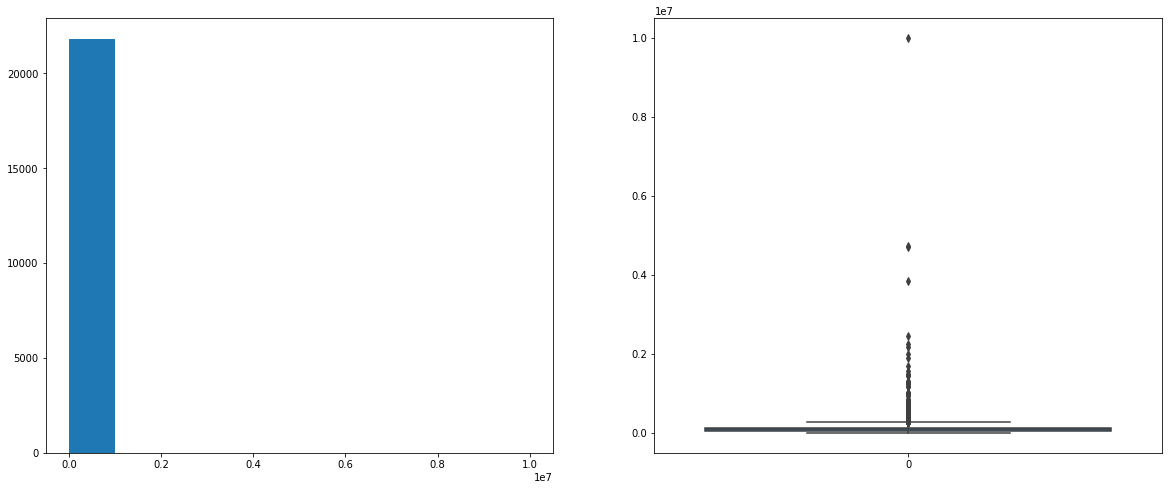

C:\Users\efrag\AppData\Local\Temp\ipykernel_20144\1597408619.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=odometer)


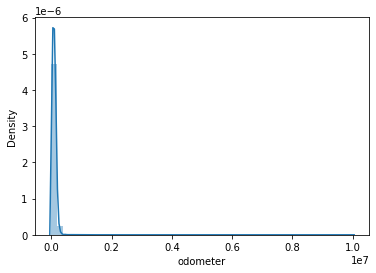

In [20]:
odometer = vehicles['odometer']
print(odometer.describe())
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.hist(odometer)
plt.subplot(1, 2, 2)
sns.boxplot(odometer);
plt.show()
sns.distplot(a=odometer)
plt.show()

Visually we can identify that there are outliers in the odometer field. i will apply 2 basic test to identy outliers into continues variables


In [21]:
def identify_outliers_zscore_column(df, column_name, threshold=3):
    data = df[column_name]
    z_scores = np.abs((data - data.mean()) / data.std())
    outliers_mask = z_scores > threshold
    return outliers_mask

def identify_outliers_iqr_column(df, column_name, threshold=1.5):
    data = df[column_name]
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    outliers_mask = (data < lower_bound) | (data > upper_bound)
    return outliers_mask

In [29]:
identify_outliers_iqr_column(vehicles, 'odometer').value_counts()

False    26757
Name: odometer, dtype: int64

In [30]:
identify_outliers_zscore_column(vehicles, 'odometer').value_counts()


False    26685
True        72
Name: odometer, dtype: int64

In [22]:
vehicles['is_odometer_outlier'] = identify_outliers_zscore_column(vehicles, 'odometer')
print('Distribution with the outliers\n', vehicles[vehicles['is_odometer_outlier'] == True]['odometer'].describe(), '\n')
print('Distribution withouth the outliers\n', vehicles[vehicles['is_odometer_outlier'] == False]['odometer'].describe())


Distribution with the outliers
 count        72.00
mean    1172447.88
std     1356176.77
min      450000.00
25%      559314.75
50%      778000.00
75%     1212058.25
max     9999999.00
Name: odometer, dtype: float64 

Distribution withouth the outliers
 count    21786.00
mean     95297.21
std      60282.22
min          0.00
25%      45150.75
50%      90504.50
75%     134999.50
max     440230.00
Name: odometer, dtype: float64


In [32]:
vehicles[vehicles['odometer'].between(135000,440230)]['odometer'].describe()

count     5447.00
mean    176409.42
std      38433.89
min     135000.00
25%     148274.00
50%     166377.00
75%     192079.00
max     440230.00
Name: odometer, dtype: float64

After reviewing this variable, we have decided to remove the 72 outliers from the sample. The minimum value for these 72 records is an odometer reading of 450,000, assuming the measurement is in miles.

In [23]:
vehicles = vehicles[vehicles['is_odometer_outlier'] == False]
del vehicles['is_odometer_outlier']

count    21786.00
mean     95297.21
std      60282.22
min          0.00
25%      45150.75
50%      90504.50
75%     134999.50
max     440230.00
Name: odometer, dtype: float64


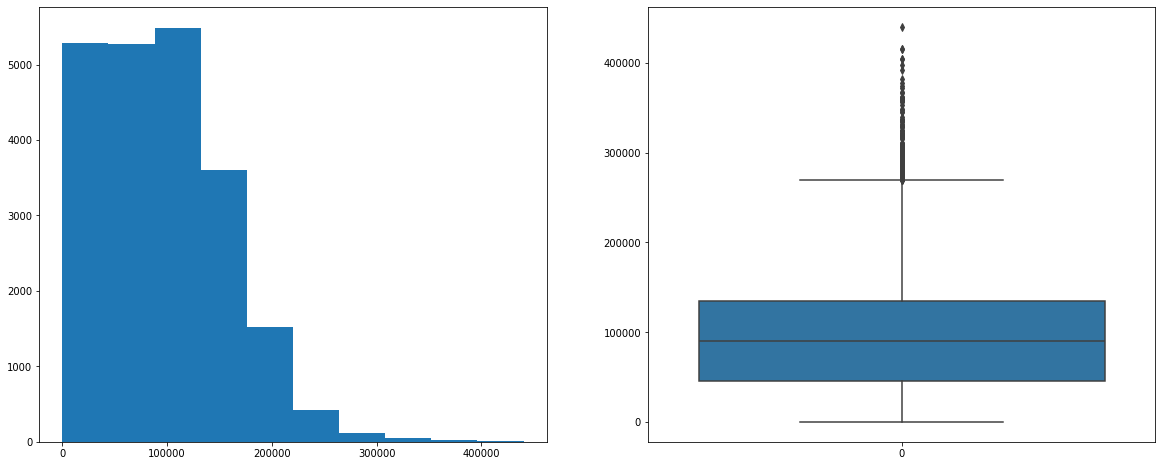

C:\Users\efrag\AppData\Local\Temp\ipykernel_20144\2624204830.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=odometer)


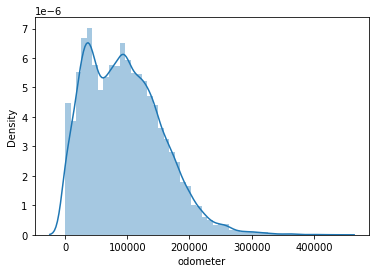

In [24]:
# conducting the same distibution analysis over the sample withouth the 72 outliers
odometer = vehicles['odometer'] 
print(odometer.describe())
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.hist(odometer)
plt.subplot(1, 2, 2)
sns.boxplot(odometer);
plt.show()
sns.distplot(a=odometer)
plt.show()

In [35]:
vehicles[vehicles['odometer'].between(0,45151)]['odometer']

3       24218.00
33      18966.00
43      37000.00
50      39850.00
52      34656.00
          ...   
26974   31155.00
26976   11111.00
26978   10453.00
26984   36863.00
26987   18124.00
Name: odometer, Length: 5447, dtype: float64

In [36]:
vehicles[vehicles['odometer'].between(0,45151)]['odometer']

3       24218.00
33      18966.00
43      37000.00
50      39850.00
52      34656.00
          ...   
26974   31155.00
26976   11111.00
26978   10453.00
26984   36863.00
26987   18124.00
Name: odometer, Length: 5447, dtype: float64

count    5447.00
mean    24864.00
std     13398.38
min         0.00
25%     15065.00
50%     26961.00
75%     36047.00
max     45146.00
Name: odometer, dtype: float64


(array([633., 249., 362., 406., 518., 587., 654., 689., 657., 692.]),
 array([    0. ,  4514.6,  9029.2, 13543.8, 18058.4, 22573. , 27087.6,
        31602.2, 36116.8, 40631.4, 45146. ]),
 <BarContainer object of 10 artists>)

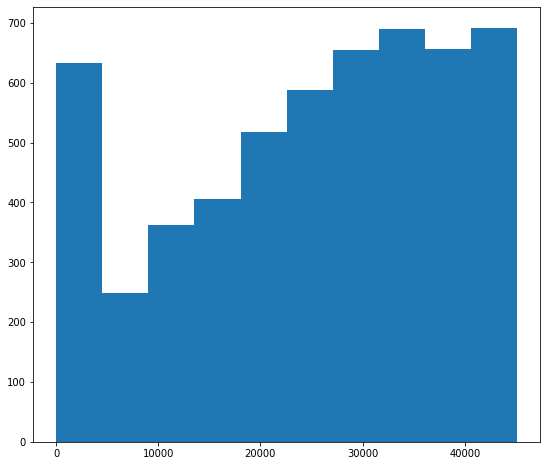

In [25]:
# Analyzing the 1st quantile
odometer = vehicles[vehicles['odometer'].between(0,45151)]['odometer']
print(odometer.describe())
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.hist(odometer)

count    1362.00
mean     5914.18
std      5300.49
min         0.00
25%       148.00
50%      5411.00
75%     10987.00
max     15060.00
Name: odometer, dtype: float64


(array([501.,  50.,  82.,  69.,  85.,  95., 118., 112., 134., 116.]),
 array([    0.,  1506.,  3012.,  4518.,  6024.,  7530.,  9036., 10542.,
        12048., 13554., 15060.]),
 <BarContainer object of 10 artists>)

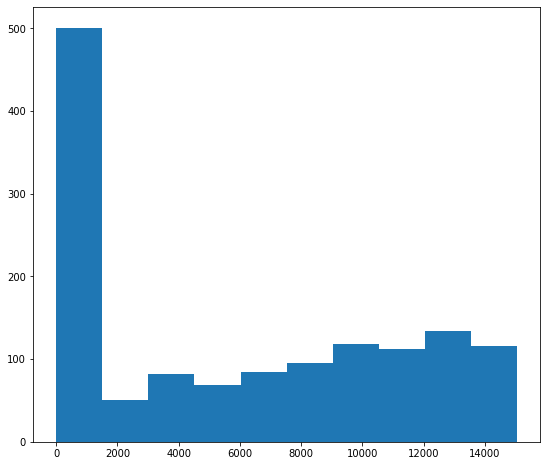

In [26]:
# Analyzing the  25% of 25%, the first 6.25% of the data.
odometer = vehicles[vehicles['odometer'].between(0,15065)]['odometer']
print(odometer.describe())
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.hist(odometer)

In [27]:
# Reviewing the years of 148 vehicles with lower odometers
print('min year:', vehicles['year'].min(), 'max year:', vehicles['year'].max())
vehicles[vehicles['odometer'].between(0,50)]['year'].value_counts()

min year: 1900.0 max year: 2021.0


2020.00    34
2019.00    29
2011.00    14
2012.00    14
2017.00    12
2015.00    11
2008.00    10
2013.00     9
2014.00     8
2016.00     7
2006.00     6
2018.00     6
2010.00     4
2009.00     4
1990.00     3
2003.00     3
1973.00     3
2007.00     3
1968.00     3
1998.00     3
2004.00     3
1999.00     2
1969.00     2
1974.00     2
1957.00     2
2001.00     1
1941.00     1
1984.00     1
1995.00     1
1994.00     1
1948.00     1
1971.00     1
2000.00     1
1972.00     1
1965.00     1
1996.00     1
2002.00     1
Name: year, dtype: int64

In [28]:
print(vehicles[(vehicles['year'] <= 2008) & (vehicles['odometer'] <= 50)]['odometer'].describe())
print(vehicles[(vehicles['year'] <= 2008) & (vehicles['odometer'] <= 50)]['year'].describe())

count   57.00
mean     3.98
std     11.10
min      0.00
25%      0.00
50%      0.00
75%      1.00
max     46.00
Name: odometer, dtype: float64
count     57.00
mean    1991.44
std       18.33
min     1941.00
25%     1973.00
50%     1999.00
75%     2006.00
max     2008.00
Name: year, dtype: float64


It's unrealistic to assume that there are vehicles with odometer readings lower than 50 miles (equivalent to 80 kilometers) from years prior to 2008, especially considering that the highest year we've found is 2021. Therefore, those 57 that meet these conditions will be removed from the vehicle dataframe.

In [29]:
condition = (vehicles['year'] <= 2008) & (vehicles['odometer'] <= 50)
vehicles = vehicles[~condition]
vehicles.shape[0]

26628

In [30]:
# validating missing values
print(vehicles['odometer'].isnull().sum())
percentage = vehicles['odometer'].isnull().sum()/vehicles.shape[0]*100
print(f'The {percentage:.2f}% of the condition field is null\t')

4899
The 18.40% of the condition field is null	


To address the missing values, which account for over 18% in this case, using the median could be a suitable choice. The median is less sensitive to extreme values, and considering that we have already removed outliers, this would be an effective way to address this issue.

In [31]:
median_odometer = vehicles['odometer'].median()
print('median ', median_odometer)
print(vehicles['odometer'].describe())

median  90753.0
count    21729.00
mean     95547.19
std      60163.06
min          0.00
25%      45516.00
50%      90753.00
75%     135000.00
max     440230.00
Name: odometer, dtype: float64


In [32]:
vehicles['odometer'].fillna(median_odometer, inplace=True)
vehicles['odometer'].describe()

count    26628.00
mean     94665.16
std      54379.13
min          0.00
25%      55880.00
50%      90753.00
75%     124005.00
max     440230.00
Name: odometer, dtype: float64

### Corralation analysis between Odometer, Condition and VIN with the target variable (Price)

#### Understading the target variable

count        26628.00
mean         55706.50
std        6841617.75
min              0.00
25%           4495.00
50%           9900.00
75%          17900.00
max     1116080943.00
Name: price, dtype: float64


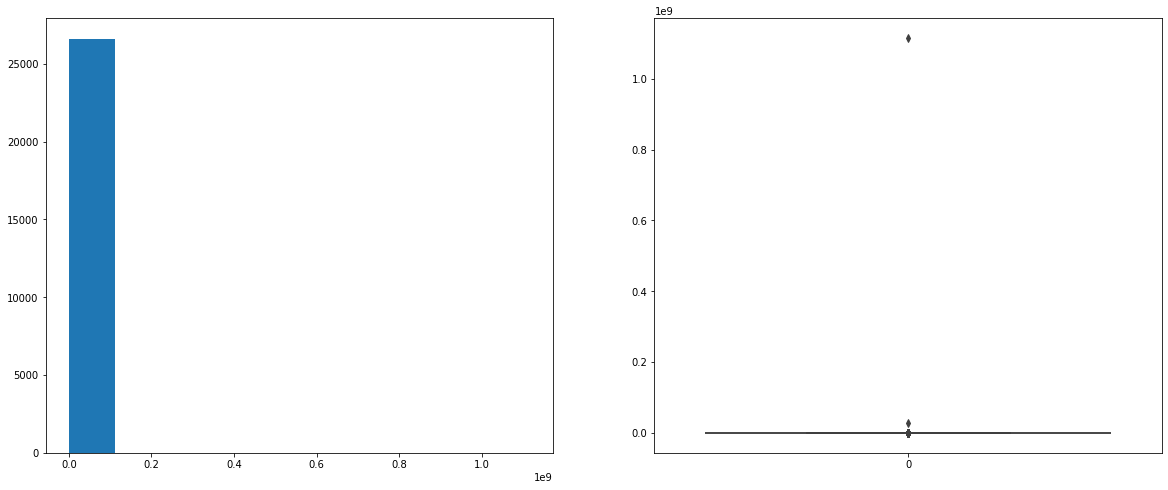

C:\Users\efrag\AppData\Local\Temp\ipykernel_20144\571422237.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=price)


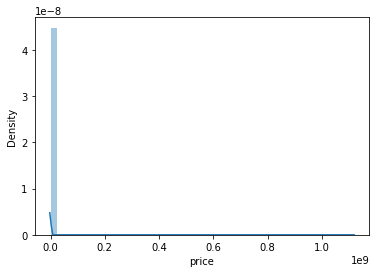

In [33]:
price = vehicles['price']
print(price.describe())
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.hist(price)
plt.subplot(1, 2, 2)
sns.boxplot(price);
plt.show()
sns.distplot(a=price)
plt.show()

In [34]:
identify_outliers_iqr_column(vehicles, 'price').value_counts()

False    25786
True       842
Name: price, dtype: int64

In [35]:
identify_outliers_zscore_column(vehicles, 'price').value_counts()

False    26626
True         2
Name: price, dtype: int64

In [36]:
vehicles['is_price_outlier'] = identify_outliers_zscore_column(vehicles, 'price')
print('Distribution with the outliers\n', vehicles[vehicles['is_price_outlier'] == True]['price'].describe(), '\n')
print('Distribution withouth the outliers\n', vehicles[vehicles['is_price_outlier'] == False]['price'].describe())

Distribution with the outliers
 count            2.00
mean     572042221.50
std      769386938.40
min       28003500.00
25%      300022860.75
50%      572042221.50
75%      844061582.25
max     1116080943.00
Name: price, dtype: float64 

Distribution withouth the outliers
 count     26626.00
mean      12741.99
std       16168.23
min           0.00
25%        4495.00
50%        9900.00
75%       17900.00
max     1234567.00
Name: price, dtype: float64


In [37]:
print(vehicles[vehicles['price'].between(200000, 1234567)]['price'].describe())
vehicles['price'] > 200000

count         6.00
mean     585770.17
std      502762.04
min      233988.00
25%      267374.25
50%      272500.00
75%      994675.25
max     1234567.00
Name: price, dtype: float64


0        False
1        False
2        False
3        False
4        False
         ...  
26983    False
26984    False
26985    False
26986    False
26987    False
Name: price, Length: 26628, dtype: bool

In [38]:
(vehicles['price'] > 200000).sum()

8

After analyzing the last Q4 quantile, of the price distribution and using outliers methology, we identifyed that only 7 cars where founded, therefore those records are going to be removed of the dataframe

In [39]:
vehicles = vehicles[vehicles['price'] <= 200000]

In [148]:
vehicles['price'].describe()

count    26620.00
mean     12612.83
std      11830.52
min          0.00
25%       4495.00
50%       9900.00
75%      17900.00
max     199888.00
Name: price, dtype: float64

In [40]:
del vehicles['is_price_outlier']

In [41]:
vehicles[['price', 'odometer']].corr(method='pearson')

,price,odometer
price,1.00,-0.33
odometer,-0.33,1.00


In [42]:
# Perform ANOVA test
f_statistic, p_value = f_oneway(
    vehicles[vehicles['condition'] == 'excellent']['price'],
    vehicles[vehicles['condition'] == 'missing/unkown']['price'],
    vehicles[vehicles['condition'] == 'good']['price'],
    vehicles[vehicles['condition'] == 'like new']['price'],
    vehicles[vehicles['condition'] == 'fair']['price'],
    vehicles[vehicles['condition'] == 'new']['price'],
    vehicles[vehicles['condition'] == 'salvage']['price']
)

# Print the results
print(f'F-statistic: {f_statistic}')
print(f'p-value: {p_value}')

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print('There is a significant difference in the means of price across condition categories.')
else:
    print('There is no significant difference in the means of price across condition categories.')


F-statistic: 81.3530595651274
p-value: 2.682770381619786e-101
There is a significant difference in the means of price across condition categories.


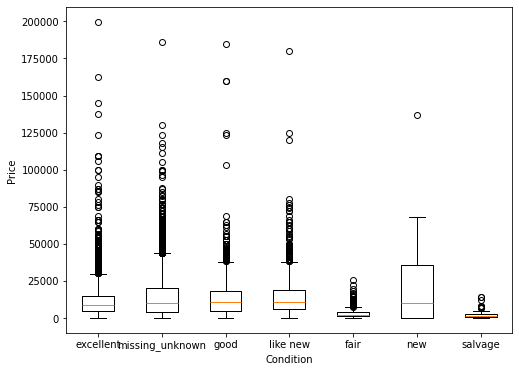

In [43]:
# Create box plots
plt.figure(figsize=(8, 6))
plt.boxplot([vehicles[vehicles['condition'] == 'excellent']['price'],
             vehicles[vehicles['condition'] == 'missing/unkown']['price'],
             vehicles[vehicles['condition'] == 'good']['price'],
             vehicles[vehicles['condition'] == 'like new']['price'],
             vehicles[vehicles['condition'] == 'fair']['price'],
             vehicles[vehicles['condition'] == 'new']['price'],
             vehicles[vehicles['condition'] == 'salvage']['price']],
            labels=['excellent', 'missing_unknown', 'good', 'like new', 'fair', 'new', 'salvage'])
plt.ylabel('Price')
plt.xlabel('Condition')
plt.show()


After eliminating outliers in the target variable, the correlation between Condition and Odometer now reveals significant patterns. We observe a negative correlation of -37% between price and odometer, indicating that as the odometer reading increases, the price of the car tends to decrease by 33%. Additionally, the condition of the cars directly impacts the pricing of the vehicles.

## Exploring numeric variables

In [56]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26620 entries, 0 to 26987
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        26620 non-null  object 
 1   price         26620 non-null  int64  
 2   year          26571 non-null  float64
 3   manufacturer  25506 non-null  object 
 4   model         26209 non-null  object 
 5   condition     26620 non-null  object 
 6   cylinders     15484 non-null  object 
 7   fuel          26460 non-null  object 
 8   odometer      26620 non-null  float64
 9   title_status  26488 non-null  object 
 10  transmission  26387 non-null  object 
 11  vin           15922 non-null  object 
 12  drive         18783 non-null  object 
 13  size          8237 non-null   object 
 14  type          19593 non-null  object 
 15  paint_color   17987 non-null  object 
 16  description   26617 non-null  object 
 17  state         26620 non-null  object 
 18  lat           26273 non-nu

In [57]:
crashes_poverty1.head(5)

,State,Postal\ncode,Number of Crashes,Poverty
0,Alabama,al,336.00,16.80
1,Alaska,ak,32.00,11.10
2,American Samoa,as,NaN,NaN
3,Arizona,az,249.00,14.10
4,Arkansas,ar,143.00,16.80


In [58]:
vehicles.select_dtypes(include=['float64', 'int64']).columns

Index(['price', 'year', 'odometer', 'lat', 'long'], dtype='object')

In [44]:
vehicles_num_variables = vehicles[['price', 'year', 'odometer','state']]
vehicles_num_variables = pd.merge(vehicles_num_variables, crashes_poverty1[['Postal\ncode', 'Number of Crashes', 'Poverty']], left_on='state', right_on='Postal\ncode')
vehicles_num_variables.drop(columns=['state', 'Postal\ncode'], inplace=True)
correlation_matrix = vehicles_num_variables.corr()
correlation_matrix

,price,year,odometer,Number of Crashes,Poverty
price,1.00,0.24,-0.33,-0.01,-0.04
year,0.24,1.00,-0.33,0.04,-0.00
odometer,-0.33,-0.33,1.00,-0.06,0.03
Number of Crashes,-0.01,0.04,-0.06,1.00,0.26
Poverty,-0.04,-0.00,0.03,0.26,1.00


Conclusions:

* We observe a weak positive correlation of 24% between price and year, suggesting that newer cars tend to be more expensive.
* We observe a weak negative correlation of -33% between price and odometer, indicating that as the odometer reading increases, the price of the car tends to decrease.
* We observe a moderate negative correlation of -46% between year and odometer, suggesting that as the odometer reading increases, the age of the car tends to be older.
* Finally, there is no correlation between the number of crashes and poverty with the price of the cars. Therefore, we will exclude them from the modeling.

## Exploring categorical variables

In [45]:
# We analyze the distributions of the categorical variables simultaneously
columnas_object = vehicles.select_dtypes(include=['object']).columns
print(f'Analisis de {len(columnas_object)} variables categoricas')
for i, colum in enumerate(columnas_object):
  print(f'Variable {i}:', f'{colum}', '')
  print('---------')
  print('Cantidad de niveles:', vehicles[colum].nunique())
  print(pd.concat([vehicles[colum].value_counts(dropna=False).rename('Freq_absoluta'),
                   round(vehicles[colum].value_counts(normalize=True, dropna=False)*100,2).rename('Freq_relativa')], axis=1))
  print('\n')

Analisis de 15 variables categoricas
Variable 0: region 
---------
Cantidad de niveles: 390
                         Freq_absoluta  Freq_relativa
bakersfield                        377           1.42
ventura county                     360           1.35
palm springs                       346           1.30
sacramento                         342           1.28
orange county                      342           1.28
...                                ...            ...
south dakota                         1           0.00
north platte                         1           0.00
scottsbluff / panhandle              1           0.00
central louisiana                    1           0.00
bismarck                             1           0.00

[390 rows x 2 columns]


Variable 1: manufacturer 
---------
Cantidad de niveles: 40
                 Freq_absoluta  Freq_relativa
ford                      4920          18.48
chevrolet                 3816          14.34
toyota                    2087      

In [46]:
vehicles[vehicles['state'] == 'ca']['region'].value_counts()

bakersfield         377
ventura county      360
palm springs        346
orange county       342
SF bay area         342
sacramento          342
los angeles         342
fresno / madera     341
modesto             340
inland empire       333
san diego           330
redding             318
reno / tahoe        314
stockton            313
san luis obispo     270
yuba-sutter         261
chico               173
monterey bay        155
gold country        132
santa barbara       131
visalia-tulare       83
merced               60
humboldt county      60
santa maria          55
imperial county      35
mendocino county     35
hanford-corcoran     18
siskiyou county       8
susanville            5
Name: region, dtype: int64

Conclusions:

* For the scope of this project, geographical variables such as 'region,' 'latitude,' 'longitude,' and 'state' seem to be redundant. For simplicity purposes, I will only keep 'state,' which has 51 categories, as compared to 'region,' which has a total of 390 categories.
* The fields 'fuel' and 'transmission' can have their missing values easily imputed with the most frequent categories, 'gas' and 'automatic,' respectively.
* In the 'drive' field, we can complete some of the 29% missing values using the 'model' or 'description' fields. The rest that couldn't be completed will be filled with 'not specified'.
* Although the 'model' field may initially seem important, it appears to be corrupted and may require a thorough cleansing process. Currently, it contains 6,298 different categories.
* Missing values in the remaining fields, such as 'cylinders,' 'type,' and 'paint_color,' will be filled with 'not specified'.
* The fields that will not be considered for the model are:
    * 'size,' as 70% of the data contains missing values.
    * 'title status,' as 95% of the data falls into the 'clean' category.
    * 'description,' which currently provides no additional information except for populating other fields such as 'drive.'
    * 'vin,' as it does not provide useful information.

## Data Cleansing

In [47]:
# Completing the field 'drive'
patterns = ['4wd', 'rwd', 'fwd']
def fill_fuel(row):
    if pd.notna(row['drive']):
        return row['drive']
    
    for pattern in patterns:
        if isinstance(row['description'], str) and (pattern in row['description'].lower()):
            return pattern
        elif isinstance(row['model'], str) and (pattern in row['model'].lower()):
            return pattern
    return np.nan  # Return NaN if no pattern is found

In [48]:
vehicles['drive_nafilled'] = vehicles[vehicles['drive'].isnull()]['drive'].fillna(vehicles.apply(fill_fuel, axis=1))
vehicles['drive'].fillna(vehicles['drive_nafilled'], inplace=True)
del vehicles['drive_nafilled']

In [49]:
vehicles['drive'].isnull().sum()/vehicles.shape[0]*100 #1549 recuperados

23.621337340345605

In [50]:
# Completing the field 'fuel'
vehicles['fuel'].fillna(vehicles['fuel'].mode().iloc[0], inplace=True)

In [51]:
# Completing the field 'transmission'
vehicles['transmission'].fillna(vehicles['transmission'].mode().iloc[0], inplace=True)

In [52]:
# 'cylinders,' 'type,' and 'paint_color,' will be filled with 'not specified.'
vehicles['cylinders'].fillna('not specified', inplace=True)
vehicles['type'].fillna('not specified', inplace=True)
vehicles['paint_color'].fillna('not specified', inplace=True)
vehicles['drive'].fillna('not specified', inplace=True)

# Modeling

## Preparing the data for traning

In [53]:
df = vehicles[['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'transmission', 
       'drive', 'type', 'paint_color', 'state']]
df.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state
0,3400,2002.00,volkswagen,excellent,4 cylinders,gas,100000.00,automatic,fwd,wagon,not specified,ca
1,6300,2004.00,chevrolet,missing/unkown,8 cylinders,gas,208942.00,automatic,4wd,pickup,white,or
2,9997,2011.00,nissan,excellent,not specified,gas,125666.00,automatic,4wd,not specified,not specified,ny
3,21504,2017.00,chevrolet,missing/unkown,4 cylinders,gas,24218.00,automatic,fwd,sedan,red,tx
4,28900,2009.00,cadillac,excellent,8 cylinders,gas,61000.00,automatic,rwd,sedan,silver,ca


In [54]:
100*df.isnull().sum()/df.shape[0]

price          0.00
year           0.18
manufacturer   4.18
condition      0.00
cylinders      0.00
fuel           0.00
odometer       0.00
transmission   0.00
drive          0.00
type           0.00
paint_color    0.00
state          0.00
dtype: float64

In [55]:
df.dropna(inplace=True)

C:\Users\efrag\AppData\Local\Temp\ipykernel_20144\1379821321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25506 entries, 0 to 26987
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         25506 non-null  int64  
 1   year          25506 non-null  float64
 2   manufacturer  25506 non-null  object 
 3   condition     25506 non-null  object 
 4   cylinders     25506 non-null  object 
 5   fuel          25506 non-null  object 
 6   odometer      25506 non-null  float64
 7   transmission  25506 non-null  object 
 8   drive         25506 non-null  object 
 9   type          25506 non-null  object 
 10  paint_color   25506 non-null  object 
 11  state         25506 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 2.5+ MB


In [57]:
df['price'] = df['price'].astype(int)
df['year'] = df['year'].astype(int)
df['manufacturer'] = df['manufacturer'].astype(str)
df['condition'] = df['condition'].astype(str)
df['cylinders'] = df['cylinders'].astype(str)
df['fuel'] = df['fuel'].astype(str)
df['odometer'] = df['odometer'].astype(int)
df['transmission'] = df['transmission'].astype(str)
df['drive'] = df['drive'].astype(str)
df['type'] = df['type'].astype(str)
df['paint_color'] = df['paint_color'].astype(str)
df['state'] = df['state'].astype(str)

C:\Users\efrag\AppData\Local\Temp\ipykernel_20144\615665935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = df['price'].astype(int)
C:\Users\efrag\AppData\Local\Temp\ipykernel_20144\615665935.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['year'].astype(int)
C:\Users\efrag\AppData\Local\Temp\ipykernel_20144\615665935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [59]:
# Identify categorical columns
categorical_columns = ['manufacturer', 'condition', 'cylinders', 'fuel', 'transmission', 'drive', 'type', 'paint_color', 'state']

# Perform one-hot encoding for categorical columns
data_encoded = pd.get_dummies(df, columns=categorical_columns)

In [60]:
# Define the target variable and features
target_variable = 'price'
features = [col for col in data_encoded.columns if col != target_variable]


In [61]:
X = data_encoded[features]
y = data_encoded[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Defining Models Structure and Grids for Hyperparameter tunning

In [62]:
# Random Forest
# Hyperparameter Grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create Random Forest model with Grid Search
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=rf_param_grid, cv=3, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Best Random Forest model
best_rf_model = rf_grid_search.best_estimator_

In [63]:
# XGBoost
# Hyperparameter Grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Create XGBoost model with Grid Search
xgb_grid_search = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid=xgb_param_grid, cv=3, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

# Best XGBoost model
best_xgb_model = xgb_grid_search.best_estimator_

In [64]:
#Saving the model for later
# Save the trained Random Forest model to a file
joblib.dump(best_rf_model, 'random_forest_model.pkl')

# Save the trained XGBoost model to a file
joblib.dump(best_xgb_model, 'xgboost_model.pkl')

# loading the model 
# Load the saved Random Forest model
loaded_random_forest_model = joblib.load('random_forest_model.pkl')

# Load the saved XGBoost model
loaded_xgboost_model = joblib.load('xgboost_model.pkl')

## Predictions with both models

In [65]:
# Make predictions on the test set
rf_predictions = best_rf_model.predict(X_test)
xgb_predictions = best_xgb_model.predict(X_test)

## Evaluate model performance

In [66]:
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)

xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_r2 = r2_score(y_test, xgb_predictions)

# Print evaluation metrics
print("Random Forest Metrics:")
print(f"MAE: {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R-squared: {rf_r2:.2f}")
print("\nXGBoost Metrics:")
print(f"MAE: {xgb_mae:.2f}")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"R-squared: {xgb_r2:.2f}")


Random Forest Metrics:
MAE: 4353.11
RMSE: 7224.88
R-squared: 0.58

XGBoost Metrics:
MAE: 4574.37
RMSE: 7366.42
R-squared: 0.56


In [67]:
# Create a dictionary to store model performance metrics
performance_data = {
    'Model': ['Random Forest', 'XGBoost'],
    'MAE': [],
    'RMSE': [],
    'R-squared': []
}

performance_data['MAE'].append(rf_mae)
performance_data['RMSE'].append(rf_rmse)
performance_data['R-squared'].append(rf_r2)

performance_data['MAE'].append(xgb_mae)
performance_data['RMSE'].append(xgb_rmse)
performance_data['R-squared'].append(xgb_r2)

# Create a DataFrame to display the performance metrics
performance_df = pd.DataFrame(performance_data)

# Print the DataFrame
print(performance_df)


           Model     MAE    RMSE  R-squared
0  Random Forest 4353.11 7224.88       0.58
1        XGBoost 4574.37 7366.42       0.56


## Feature importance

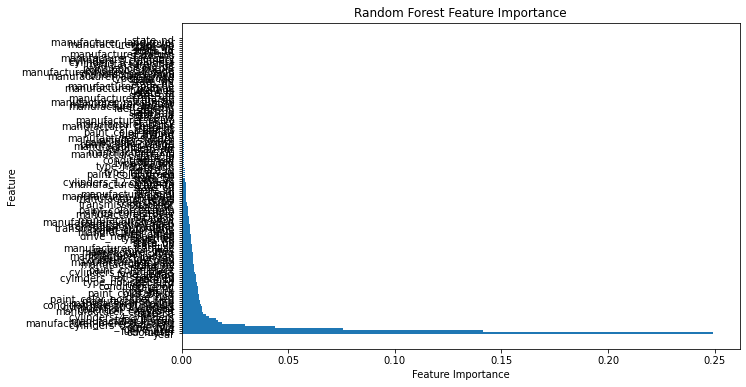

In [68]:
# RF
# Get feature importances
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort features by importance (descending order)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()

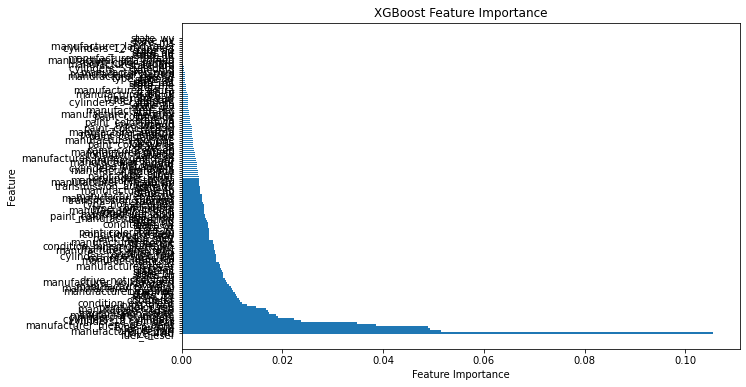

In [69]:
# XGBoost
# Get feature importances 
feature_importances = best_xgb_model.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort features by importance (descending order)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.show()

## Improving the models



Scaling variables

In [72]:
# Use StandardScaler to scale the numerical features
numerical_features = ['year', 'odometer']
scaler = StandardScaler()
data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])

In [74]:
# Define the target variable and features
target_variable = 'price'
features = [col for col in data_encoded.columns if col != target_variable]

X = data_encoded[features]
y = data_encoded[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
# Random Forest
# Hyperparameter Grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create Random Forest model with Grid Search
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=rf_param_grid, cv=3, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Best Random Forest model
best_rf_model = rf_grid_search.best_estimator_

In [76]:
# XGBoost
# Hyperparameter Grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Create XGBoost model with Grid Search
xgb_grid_search = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid=xgb_param_grid, cv=3, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

# Best XGBoost model
best_xgb_model = xgb_grid_search.best_estimator_

In [77]:
#Saving the model for later
# Save the trained Random Forest model to a file
joblib.dump(best_rf_model, 'random_forest_model_scaled.pkl')

# Save the trained XGBoost model to a file
joblib.dump(best_xgb_model, 'xgboost_model_scaled.pkl')

# loading the model 
# Load the saved Random Forest model
loaded_random_forest_model_scaled = joblib.load('random_forest_model_scaled.pkl')

# Load the saved XGBoost model
loaded_xgboost_model_scaled = joblib.load('xgboost_model_scaled.pkl')

In [78]:
# Make predictions on the test set
rf_predictions = best_rf_model.predict(X_test)
xgb_predictions = best_xgb_model.predict(X_test)

In [79]:
# Evaluating the performance
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)

xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_r2 = r2_score(y_test, xgb_predictions)

# Print evaluation metrics
print("Random Forest Metrics:")
print(f"MAE: {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R-squared: {rf_r2:.2f}")
print("\nXGBoost Metrics:")
print(f"MAE: {xgb_mae:.2f}")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"R-squared: {xgb_r2:.2f}")

Random Forest Metrics:
MAE: 4352.87
RMSE: 7225.47
R-squared: 0.58

XGBoost Metrics:
MAE: 4574.37
RMSE: 7366.42
R-squared: 0.56


In [80]:
# Create a dictionary to store model performance metrics
performance_data = {
    'Model': ['Random Forest', 'XGBoost'],
    'MAE': [],
    'RMSE': [],
    'R-squared': []
}

performance_data['MAE'].append(rf_mae)
performance_data['RMSE'].append(rf_rmse)
performance_data['R-squared'].append(rf_r2)

performance_data['MAE'].append(xgb_mae)
performance_data['RMSE'].append(xgb_rmse)
performance_data['R-squared'].append(xgb_r2)

# Create a DataFrame to display the performance metrics
performance_df = pd.DataFrame(performance_data)

# Print the DataFrame
print(performance_df)

           Model     MAE    RMSE  R-squared
0  Random Forest 4352.87 7225.47       0.58
1        XGBoost 4574.37 7366.42       0.56


Using other alternative to improve the model understanding of the data, it consist in change to replace a each categorical variable with its frequency encoding on a high-cardinality categorical variable, as follows

In [102]:
df1 = df.copy()
# Calculate the frequency encoding for each categorical feature
for feature in categorical_columns:
    frequency_encoding = df1[feature].value_counts(normalize=True).to_dict()
    df1[feature + '_frequency_encoded'] = df1[feature].map(frequency_encoding)

# Drop the original categorical features if needed
df1.drop(columns=categorical_columns, inplace=True)

In [103]:
# Define the target variable and features
target_variable = 'price'
features = [col for col in df1.columns if col != target_variable]

# Scaling the data 
scaler = StandardScaler()
df1[features] = scaler.fit_transform(df1[features])

In [104]:
X = df1[features]
y = df1[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
# Random Forest
# Hyperparameter Grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create Random Forest model with Grid Search
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=rf_param_grid, cv=3, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Best Random Forest model
best_rf_model = rf_grid_search.best_estimator_

In [106]:
# XGBoost
# Hyperparameter Grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Create XGBoost model with Grid Search
xgb_grid_search = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid=xgb_param_grid, cv=3, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

# Best XGBoost model
best_xgb_model = xgb_grid_search.best_estimator_

In [107]:
#Saving the model for later
# Save the trained Random Forest model to a file
joblib.dump(best_rf_model, 'random_forest_model_freq_enco_scaled.pkl')

# Save the trained XGBoost model to a file
joblib.dump(best_xgb_model, 'xgboost_model_freq_enco_scaled.pkl')

# loading the model 
# Load the saved Random Forest model
loaded_random_forest_model_scaled = joblib.load('random_forest_model_freq_enco_scaled.pkl')

# Load the saved XGBoost model
loaded_xgboost_model_scaled = joblib.load('xgboost_model_freq_enco_scaled.pkl')

In [108]:
# Make predictions on the test set
rf_predictions = best_rf_model.predict(X_test)
xgb_predictions = best_xgb_model.predict(X_test)

In [109]:
# Evaluating the performance
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)

xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_r2 = r2_score(y_test, xgb_predictions)

# Print evaluation metrics
print("Random Forest Metrics:")
print(f"MAE: {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R-squared: {rf_r2:.2f}")
print("\nXGBoost Metrics:")
print(f"MAE: {xgb_mae:.2f}")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"R-squared: {xgb_r2:.2f}")

Random Forest Metrics:
MAE: 4557.94
RMSE: 7509.52
R-squared: 0.55

XGBoost Metrics:
MAE: 4582.42
RMSE: 7410.25
R-squared: 0.56


In [110]:
# Create a dictionary to store model performance metrics
performance_data = {
    'Model': ['Random Forest', 'XGBoost'],
    'MAE': [],
    'RMSE': [],
    'R-squared': []
}

performance_data['MAE'].append(rf_mae)
performance_data['RMSE'].append(rf_rmse)
performance_data['R-squared'].append(rf_r2)

performance_data['MAE'].append(xgb_mae)
performance_data['RMSE'].append(xgb_rmse)
performance_data['R-squared'].append(xgb_r2)

# Create a DataFrame to display the performance metrics
performance_df = pd.DataFrame(performance_data)

# Print the DataFrame
print(performance_df)

           Model     MAE    RMSE  R-squared
0  Random Forest 4557.94 7509.52       0.55
1        XGBoost 4582.42 7410.25       0.56


Removing some features 

In [116]:
for column in categorical_columns:
    print(df[column].unique())

['volkswagen' 'chevrolet' 'nissan' 'cadillac' 'jeep' 'ford' 'bmw'
 'chrysler' 'honda' 'rover' 'dodge' 'buick' 'mercedes-benz' 'toyota' 'kia'
 'ram' 'subaru' 'gmc' 'hyundai' 'jaguar' 'saturn' 'lexus' 'mini' 'acura'
 'lincoln' 'volvo' 'infiniti' 'mitsubishi' 'mazda' 'mercury' 'pontiac'
 'audi' 'fiat' 'alfa-romeo' 'tesla' 'harley-davidson' 'ferrari'
 'land rover' 'porche' 'datsun']
['excellent' 'missing/unkown' 'good' 'like new' 'fair' 'salvage' 'new']
['4 cylinders' '8 cylinders' 'not specified' '6 cylinders' '10 cylinders'
 '5 cylinders' '3 cylinders' 'other' '12 cylinders']
['gas' 'other' 'diesel' 'hybrid' 'electric']
['automatic' 'manual' 'other']
['fwd' '4wd' 'rwd' 'not specified']
['wagon' 'pickup' 'not specified' 'sedan' 'coupe' 'van' 'mini-van' 'SUV'
 'truck' 'other' 'hatchback' 'convertible' 'bus' 'offroad']
['not specified' 'white' 'red' 'silver' 'grey' 'black' 'blue' 'brown'
 'custom' 'purple' 'green' 'yellow' 'orange']
['ca' 'or' 'ny' 'tx' 'il' 'fl' 'wa' 'ks' 'id' 'oh' 'nc' 'w

In [143]:
# Droping only 'paint_color', 'state'
categorical_columns = ['manufacturer', 'condition', 'cylinders', 'fuel', 'transmission', 'drive', 'type']
df1 = df[['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'transmission', 'drive', 'type']]

In [144]:
# Perform one-hot encoding for categorical columns
data_encoded = pd.get_dummies(df1, columns=categorical_columns)

# Define the target variable and features
target_variable = 'price'
features = [col for col in data_encoded.columns if col != target_variable]

X = data_encoded[features]
y = data_encoded[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [145]:
# Random Forest
# Hyperparameter Grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create Random Forest model with Grid Search
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=rf_param_grid, cv=3, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Best Random Forest model
best_rf_model = rf_grid_search.best_estimator_

In [146]:
# XGBoost
# Hyperparameter Grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Create XGBoost model with Grid Search
xgb_grid_search = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid=xgb_param_grid, cv=3, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

# Best XGBoost model
best_xgb_model = xgb_grid_search.best_estimator_

In [147]:
#Saving the model for later
# Save the trained Random Forest model to a file
joblib.dump(best_rf_model, 'random_forest_model_nopaint_nostate.pkl')

# Save the trained XGBoost model to a file
joblib.dump(best_xgb_model, 'xgboost_model_nopaint_nostate.pkl')

# loading the model 
# Load the saved Random Forest model
loaded_random_forest_model = joblib.load('random_forest_model_nopaint_nostate.pkl')

# Load the saved XGBoost model
loaded_xgboost_model = joblib.load('xgboost_model_nopaint_nostate.pkl')

# Make predictions on the test set
rf_predictions = best_rf_model.predict(X_test)
xgb_predictions = best_xgb_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)

xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_r2 = r2_score(y_test, xgb_predictions)

# Create a dictionary to store model performance metrics
performance_data = {
    'Model': ['Random Forest', 'XGBoost'],
    'MAE': [],
    'RMSE': [],
    'R-squared': []
}

performance_data['MAE'].append(rf_mae)
performance_data['RMSE'].append(rf_rmse)
performance_data['R-squared'].append(rf_r2)

performance_data['MAE'].append(xgb_mae)
performance_data['RMSE'].append(xgb_rmse)
performance_data['R-squared'].append(xgb_r2)

# Create a DataFrame to display the performance metrics
performance_df = pd.DataFrame(performance_data)

# Print the DataFrame
print(performance_df)



           Model     MAE    RMSE  R-squared
0  Random Forest 4536.05 7420.32       0.56
1        XGBoost 4672.60 7563.29       0.54


# 1.  Data Analysis

In this part I will compile all the results in the given format in the origianl PDF file 

## Part A: Questions
Take each of the following 3 variables:

- odometer
- condition
- vin

For each of them analyze the following points:
1. Evaluate the completeness of the variable and highlight any findings
you think relevant for a discussion.
2. Evaluate how well the value discriminates your dependent variable
and determine if you would use it in your model.
3. If the previous answer was affirmative then how would you propose to
include it in your model. That is, what transformations, techniques,
or tools would you use to include it.


In [ ]:
vehicles[["odometer","condition","vin"]]

### 1. Evaluate the completeness of the variable and highlight any findings you think relevant for a discussion.


#### 1.1 Odometer

General statistics:

- Completeness: 18.31% of the data is null.
- Outliers where identified in the first graphical analysis. 2 basic tests took place to identy outliers. The Z-score and the Interquartile Range (IQR). Implementaion the Z-score 72 records that were identifyed as outliers were removed. 
- Finally, after reviewing the values closest to zero, we to assume to be unrealistic that there are vehicles with odometer readings lower than 50 miles (equivalent to 80 kilometers) from years prior to 2008, especially considering that the highest year we've found is 2021. Therefore, those 57 that meet these conditions will be removed from the vehicle dataframe.
- After pruning this variable with the outliers analysis, the missing values where filled using the median, since is less sensitive to extreme values, and considering that we have already removed outliers, this would be an effective way to address this issue.


#### 1.2 Condition

General statistics:

- Completeness: 43.12% of the data is null.
- Since approximately 43% of the data in this field is missing (NaN), here are 3 possible approaches:

    1. **Impute missing values:** with the most frequent category, which in this case would be "excellent" 
    2. **Create a new category:** named "missing" or "unknown" to explicitly indicate that the condition information is not available for these entries. I recommend using this approach so we don't lose valuable information.
    3. **Predictive Imputation:** With the additional features that are correlated with the 'condition' of the vehicle, we can employ those features to predict the missing values in the 'condition' field using classification models. We leave this option for future processes.

- We can define an hypothesis that if the condition of the car afects the final price

#### 1.3 VIN

After conducting several analyses on this variable, I have reached the following conclusions:

General statistics:

- Completeness: 40.2% of the data is null.
- Due to the fact that 45% of the VINs are duplicated in the dataset, this will not be a problem, as these fields will not be included as dependent - variables. 89.93% of those duplicated VINs are Null.
- 98% of the VINs have a length of 17 characters. This is a strong indicator that possible future VINs under 17 characters long should be reviewed.
- Unusual VINs found:

Total of unusual vins 20
- 000000000000        3
- Van Truck Center    2
- call 4076586667     2
- 899A215197          2
- Cash only OBO       2
- Van Truck Toyota    2
- 1Z37T3S423413       1
- SHOWN BY APPT.      1
- 784512              1
- 342671M111204       1
- na                  1
- JNT16276G809        1
- 1                   1
- AZ152792            1
- Email for VIN       1
- JA11208484          1
- TMDZ5BN1GM008922    1
- 0000                1
- IDRIVEFRESNO.COM    1
- D00341              1

### 2. Evaluate how well the value discriminates your dependent variable and determine if you would use it in your model.

After eliminating outliers in the target variable, the correlation between Condition and Odometer now reveals significant patterns.

#### 2.1 Odometer

We observe a weak negative correlation of -33% between price and odometer, indicating that as the odometer reading increases, the price of the car tends to decrease.

#### 2.2 Condition


**Null Hypothesis (H0):** It assumes that there's no significant difference in the means of the groups. In our case, it means the 'price' doesn't significantly vary between 'condition' categories.

**Alternative Hypothesis (Ha):** It suggests that there is a significant difference in the means of at least one group. In our case, it suggests that the 'price' varies significantly among 'condition' categories.

After performing an ANOVA test, we identified a p-value of 2.682770381619786e-101, which is less than the significance level of 0.05. Therefore, we conclude that the condition of the cars directly impacts the pricing of the vehicles.

#### 2.3 VIN

VINs should serve as unique identifiers for vehicles (id); however, they lack the predictive power and meaningful information needed for accurately forecasting a vehicle's price. It's generally more effective to utilize other relevant attributes that have a direct relationship with the target variable (price) when constructing a predictive model for vehicle prices. In this specific case scenario, the VIN field should also not be used as an ID.

### 3. If the previous answer was affirmative then how would you propose to include it in your model. That is, what transformations, techniques, or tools would you use to include it.

I have included only the 'odometer' and 'condition' variables in the modeling process. For 'odometer,' I could perform standardization (z-score) or min-max scaling. Regarding 'Condition,' as it's a categorical variable with multiple categories (e.g., 'excellent,' 'good,' 'like new,' 'fair,' 'new,' 'salvage'), we can use one-hot encoding. This technique creates binary variables for each category, indicating whether a car falls into that category or not. These techniques are often used in sensitive models, such as NN's.

In this particular problem, we will implement Decision Tree-Based Models such as Random Forest (RF) or XGBoost. These types of models can handle categorical variables without the need for one-hot encoding or similar techniques, as they can naturally split on categorical features. Same for continues variables.

## Part B: Are there any duplicate, redundant or irrelevant variables in your data set? If there are, how would you deal with them?

Conclusions:

* Due to the fact that 45% of the VINs are duplicated in the dataset, this will not be a problem, as these fields will not be included as dependent - variables. 89.93% of those duplicated VINs are Null.
* For the scope of this project, geographical variables such as 'region,' 'latitude,' 'longitude,' and 'state' seem to be redundant. For simplicity purposes, I will only keep 'state,' which has 51 categories, as compared to 'region,' which has a total of 390 categories.
* The fields 'fuel' and 'transmission' can have their missing values easily imputed with the most frequent categories, 'gas' and 'automatic,' respectively.
* In the 'drive' field, we can complete some of the 29% missing values using the 'model' or 'description' fields.
* Although the 'model' field may initially seem important, it appears to be corrupted and may require a thorough cleansing process. Currently, it contains 6,298 different categories.
* Missing values in the remaining fields, such as 'cylinders,' 'type,' and 'paint_color,' will be filled with 'not specified.'
* The fields that will not be considered for the model are:
    * 'size,' as 70% of the data contains missing values.
    * 'title status,' as 95% of the data falls into the 'clean' category.
    * 'description,' which currently provides no additional information except for populating other fields such as 'drive.'
    * 'vin,' as it does not provide useful information.

#  2. Model building

## 2.1 Which model to implemente? 
What model would you propose to solve the problem and why did you
choose it?

I will prepare two options, the Random Forest and XGBoost are powerful ensemble methods that can handle both numerical and categorical features, making them suitable for this mixed data type problem.

## 2.2 Performance Metrics
What performance metrics would you use and discuss whether they are valid and their results

* Mean Absolute Error (MAE): It measures the average absolute difference between predicted and actual prices. It's easy to interpret since it's in the same unit as the target variable.
* Mean Squared Error (MSE): It measures the average of the squared differences between predicted and actual prices. It punishes larger errors more than MAE.
* Root Mean Squared Error (RMSE): It's the square root of MSE and provides a measure in the original unit, which can be more interpretable.
* R-squared (R²): It measures the proportion of the variance in the target variable explained by the model. Higher R² values indicate better model fit.

# 2.3 Presentation 

How would you present your model to the business stakeholder and ensure
them that it works?

I would like to present in a mix of powerpoint presentation and a functional app. where it shows basic comparison with the price of the market, with out model prediction. also this contains the likelygood of purchasing with the % of profit

# 2.4 Model Monitoring System Proposal


Discuss how would you monitor your model in 3 months time to determine
its validity. (No Code)


* Continuously monitor the distribution of input data to detect any significant shifts. If the distribution changes substantially, it may indicate that we needs to retrain the model with the new distributions of the market
* Keep track of the primary performance metrics. Set up automated alerts for any significant degradation in performance in MAE and RMSE.
* Keep the user feedback as closed as possible this can provide valuable insights into model performance.

end